<a href="https://colab.research.google.com/github/natalialopezg/Monografia-EACD/blob/master/Exploratory_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size="2">Monografía - Especialización en Analítica y Ciencia de Datos - Universidad de Antioquia - 2024</font>

<font size="6"> Notebook: Data preprocessing </font>

<font size="3"> Natalia López Grisales</font>


<br />

# Abstract
In this notebook the exploratory analysis of colorectal polyp images obtained from colonoscopy videos is performed. The images are part of the datasets [CVC-ClinicDB](https://polyp.grand-challenge.org/CVCClinicDB/), [Kvasir-SEG](https://datasets.simula.no/kvasir-seg/), [CVC-300 (EndoScene)](http://adas.cvc.uab.es/endoscene) and [CVC-ColonDB](http://mv.cvc.uab.es/projects/colon-qa/cvc-colondb) . The preprocessing is performed as a preparation of the data for further development of segmentation models.


# Requirements
For the correct execution of the notebook, dependencies are presented together with their versions used in the development:


    pandas==2.0.3
    numpy==1.25.2
    opencv-python==4.8.0.76
    Pillow==9.4.0
    pylibtiff==0.6.1
    matplotlib==3.7.1
    seaborn==0.13.1



In [1]:
!pip3 install pylibtiff

# Importing libraries

In [2]:
# Data analysis and manipulation
import pandas as pd
import numpy as np

# Computer vision
import cv2
from PIL import Image
from libtiff import TIFF

# Progress meter for loops
from tqdm.notebook import tqdm

# Image and graphs visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous operating system interfaces
import os

# Function definition

In [3]:
def comparison_img_msk(dataset, dataset_name):
  '''
    Returns the figure build from input parameters.

      Parameters:
              dataset (dataframe): data to be plotted.
              dataset_name (string): Name of dataset.

      Returns:
              Plot of figure
  '''
  #set seaborn plotting aesthetics
  sns.set(context="paper", style='darkgrid')

  images_data = dataset[['filename', 'width_img', 'height_img','aspect_ratio_img']]
  mask_data = dataset[['filename', 'width_msk', 'height_msk','aspect_ratio_msk']]

  fig, axes = plt.subplots(1, 2, figsize=(10, 3))

  plot = sns.scatterplot(data=images_data,
                  x="width_img",
                  y="height_img",
                  hue="aspect_ratio_img",
                  size="aspect_ratio_img",
                  sizes=(70, 350),
                  legend = False,
                  ax= axes[0],
                  palette = 'crest',
                  linewidth = 0.4)
  axes[0].set_title('images', fontsize=12)
  axes[0].set_ylabel('height')
  axes[0].set_xlabel('width')
  norm = plt.Normalize(images_data['aspect_ratio_img'].min(), images_data['aspect_ratio_img'].max())
  sm = plt.cm.ScalarMappable(cmap="crest", norm=norm)
  cbar = fig.colorbar(sm,ax=axes[0])
  cbar.set_label('aspect ratio', rotation=90)


  sns.scatterplot(data=mask_data,
                  x="width_msk",
                  y="height_msk",
                  hue="aspect_ratio_msk",
                  size="aspect_ratio_msk",
                  sizes=(70, 350),
                  legend = False,
                  ax= axes[1],
                  palette = 'crest',
                  linewidth = 0.4)
  axes[1].set_title('masks', fontsize=12)
  axes[1].set_ylabel('height')
  axes[1].set_xlabel('width')
  norm = plt.Normalize(mask_data['aspect_ratio_msk'].min(), mask_data['aspect_ratio_msk'].max())
  sm = plt.cm.ScalarMappable(cmap="crest", norm=norm)
  cbar = fig.colorbar(sm,ax=axes[1])
  cbar.set_label('aspect ratio', rotation=90)

  fig.tight_layout()
  fig.suptitle(f"Comparison of image and masks properties in the {dataset_name} dataset",
              fontsize=16,
              fontweight='bold',
              y=1.07)
  plt.show()


def images_visualization(ncols,folder,directory):
  """
    Visualizes images and corresponding masks from a specified folder.

    Parameters:
    - ncols (int): Number of columns to display the images.
    - folder (str): Name of the folder containing images and masks.
    - directory (str): Directory where the folder is located.

    Returns:
    - None

    Example:
    images_visualization(3, "example_folder", "/path/to/directory")
    """
  #set seaborn plotting aesthetics as default
  sns.set()

  nrows=2

  images_path = f"{directory}/{folder}/images"
  images_list = os.listdir(images_path)

  masks_path = f"{directory}/{folder}/masks"
  masks_list = os.listdir(masks_path)

  fig, axes = plt.subplots(nrows,ncols, figsize=(10, nrows*3))

  for i, image_filename in enumerate(images_list[0:ncols]):
    image_filename = images_list[i]

    #image
    ax_cond = axes[0,i]
    image_path = f"{images_path}/{image_filename}"

    if image_filename[-3:] == 'tif':
      input = TIFF.open(image_path).read_image()
      image = Image.fromarray(input)
    else:
      image_bgr = cv2.imread(image_path)
      image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    ax_cond.imshow(image)
    ax_cond.grid(False)

    #Mask
    ax_cond = axes[1,i]
    image_path = f"{masks_path}/{image_filename}"
    if image_filename[-3:] == 'tif':
      input = TIFF.open(image_path).read_image()
      image = Image.fromarray(input)
    else:
      image_bgr = cv2.imread(image_path)
      image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    ax_cond.imshow(image)
    ax_cond.grid(False)

  fig.tight_layout()
  fig.suptitle(f"Images from {folder}", fontsize=16, fontweight='bold', y=1.05)
  plt.show()


In [4]:
# Parameters
directory = '/content/drive/MyDrive/Classroom/Monografia/datasets'
folders = ["kvasir-seg",
           "cvc-clinicdb",
           "cvc-colondb",
           "cvc-300"]
output_folder = '/content/drive/MyDrive/Classroom/Monografia'

# Data exploration

## Analyzing the data

Loading metadata files and merging image and masks properties:

In [5]:
# Define dataframe variables
kvasirseg_img_metadata = pd.DataFrame()
kvasirseg_msk_metadata = pd.DataFrame()
kvasirseg_join_img_msk = pd.DataFrame()
cvcclinicdb_img_metadata = pd.DataFrame()
cvcclinicdb_msk_metadata = pd.DataFrame()
cvcclinicdb_join_img_msk = pd.DataFrame()
cvccolondb_img_metadata = pd.DataFrame()
cvccolondb_msk_metadata = pd.DataFrame()
cvccolondb_join_img_msk = pd.DataFrame()
cvc300_img_metadata = pd.DataFrame()
cvc300_msk_metadata = pd.DataFrame()
cvc300_join_img_msk = pd.DataFrame()

print("Reading files...")
for folder in folders:
  dataset = ''.join(e for e in folder if e.isalnum())

  # Reading metadata csv files
  images_metadata_path = f"{output_folder}/metadata/{folder}/images_metadata.txt"
  images_metadata = pd.read_csv(images_metadata_path, sep=';')
  string_read_csv = f"{dataset}_img_metadata = pd.read_csv(images_metadata_path, sep=';')"
  exec(string_read_csv)
  print(f"\n  • {dataset}_img_metadata")

  masks_metadata_path = f"{output_folder}/metadata/{folder}/masks_metadata.txt"
  masks_metadata = pd.read_csv(masks_metadata_path, sep=';')
  string_read_csv = f"{dataset}_msk_metadata = pd.read_csv(masks_metadata_path, sep=';')"
  exec(string_read_csv)
  print(f"  • {dataset}_msk_metadata")

  # Calculating aspect ratio
  string_aspect_ratio = f"{dataset}_img_metadata['aspect_ratio'] = {dataset}_img_metadata['height'] / {dataset}_img_metadata['width']"
  exec(string_aspect_ratio)
  string_aspect_ratio = f"{dataset}_msk_metadata['aspect_ratio'] = {dataset}_msk_metadata['height'] / {dataset}_msk_metadata['width']"
  exec(string_aspect_ratio)

  string_set_index = f"{dataset}_img_metadata.set_index(['dataset', 'filename'], inplace =True)"
  exec(string_set_index)
  string_set_index = f"{dataset}_msk_metadata.set_index(['dataset', 'filename'], inplace =True)"
  exec(string_set_index)

  # Merging image and masks properties
  string_join = f"{dataset}_join_img_msk = {dataset}_img_metadata.join({dataset}_msk_metadata,\
                                                                       on=['dataset', 'filename'],\
                                                                       how= 'outer',\
                                                                       lsuffix='_img',\
                                                                       rsuffix='_msk'\
                                                                       ).reset_index()"
  exec(string_join)


Reading files...

  • kvasirseg_img_metadata
  • kvasirseg_msk_metadata

  • cvcclinicdb_img_metadata
  • cvcclinicdb_msk_metadata

  • cvccolondb_img_metadata
  • cvccolondb_msk_metadata

  • cvc300_img_metadata
  • cvc300_msk_metadata


Exploring data:

In [6]:
kvasirseg_join_img_msk.sample(n=5, random_state=1)

,dataset,filename,height_img,width_img,size_img,aspect_ratio_img,height_msk,width_msk,size_msk,aspect_ratio_msk
507,kvasir-seg,cju787jnjzjuj0871p94nck9g.jpg,546,626,1025388,0.872204,576,720,414720,0.8
818,kvasir-seg,cju857ad0l88m0817qx4cwxnf.jpg,529,623,988701,0.849117,576,720,414720,0.8
452,kvasir-seg,cju2wtwj87kys0855kx6mddzw.jpg,547,626,1027266,0.873802,576,720,414720,0.8
368,kvasir-seg,cju2nnqrqzp580855z8mhzgd6.jpg,518,569,884226,0.910369,576,720,414720,0.8
242,kvasir-seg,cju2tvrvm53ws0801a0jfjdxg.jpg,531,568,904824,0.934859,576,720,414720,0.8


In [7]:
# check for null values

null_values_kvasirseg = pd.DataFrame(kvasirseg_join_img_msk.isnull().sum()).reset_index().rename(columns={'index':'Columna',0:'Cantidad de valores nulos'})
null_values_cvcclinicdb = pd.DataFrame(cvcclinicdb_join_img_msk.isnull().sum()).reset_index().rename(columns={'index':'Columna',0:'Cantidad de valores nulos'})
null_values_cvccolondb = pd.DataFrame(cvccolondb_join_img_msk.isnull().sum()).reset_index().rename(columns={'index':'Columna',0:'Cantidad de valores nulos'})
null_values_cvc300 = pd.DataFrame(cvc300_join_img_msk.isnull().sum()).reset_index().rename(columns={'index':'Columna',0:'Cantidad de valores nulos'})

print(f"  Null values per column in Kvasir-SEG\n{'--'*25}")
display(null_values_kvasirseg.set_index('Columna').transpose())

print(f"\n  Null values per column in cvc-clinicdb\n{'--'*25}")
display(null_values_cvcclinicdb.set_index('Columna').transpose())

print(f"\n  Null values per column in cvc-colondb\n{'--'*25}")
display(null_values_cvccolondb.set_index('Columna').transpose())

print(f"\n  Null values per column in cvc-300\n{'--'*25}")
display(null_values_cvc300.set_index('Columna').transpose())

  Null values per column in Kvasir-SEG
--------------------------------------------------


Columna,dataset,filename,height_img,width_img,size_img,aspect_ratio_img,height_msk,width_msk,size_msk,aspect_ratio_msk
Cantidad de valores nulos,0,0,0,0,0,0,0,0,0,0



  Null values per column in cvc-clinicdb
--------------------------------------------------


Columna,dataset,filename,height_img,width_img,size_img,aspect_ratio_img,height_msk,width_msk,size_msk,aspect_ratio_msk
Cantidad de valores nulos,0,0,0,0,0,0,0,0,0,0



  Null values per column in cvc-colondb
--------------------------------------------------


Columna,dataset,filename,height_img,width_img,size_img,aspect_ratio_img,height_msk,width_msk,size_msk,aspect_ratio_msk
Cantidad de valores nulos,0,0,0,0,0,0,0,0,0,0



  Null values per column in cvc-300
--------------------------------------------------


Columna,dataset,filename,height_img,width_img,size_img,aspect_ratio_img,height_msk,width_msk,size_msk,aspect_ratio_msk
Cantidad de valores nulos,0,0,0,0,0,0,0,0,0,0


This indicates that the number of images is equal to the number of masks and that each image record found its mask record in both datasets.

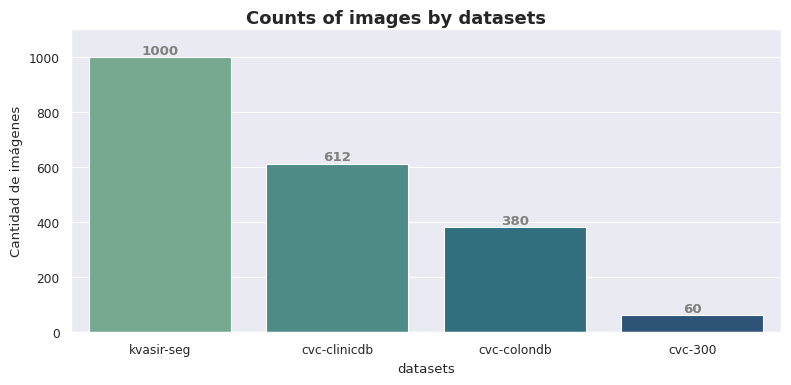

In [8]:
#set seaborn plotting aesthetics as default
sns.set(context="paper", style='darkgrid')
fig, axes = plt.subplots(1, 1, figsize=(8, 4))
sns.countplot(data = pd.concat([kvasirseg_join_img_msk[['dataset','filename']],
                                cvcclinicdb_join_img_msk[['dataset','filename']],
                                cvccolondb_join_img_msk[['dataset','filename']],
                                cvc300_join_img_msk[['dataset','filename']]]),
              x = 'dataset',
              hue= 'dataset',
              ax = axes,
              orient ='v',
              palette ='crest'
              )

for bars in axes.containers:
  axes.bar_label(bars, fmt='%.0f',fontweight = "bold", color ='gray')

axes.margins(y=0.1)

axes.set_xlabel("datasets")
axes.set_ylabel("Cantidad de imágenes")

fig.tight_layout()
plt.subplots_adjust(top = 0.9)

fig.suptitle("Counts of images by datasets", fontsize = 13, fontweight = "bold", y= 0.95);


The kvasir-seg dataset is the most complete. The sum of the other data sets is approximately equal to the number of the kavasir-seg dataset.

Comparison between images and masks for each dataset:

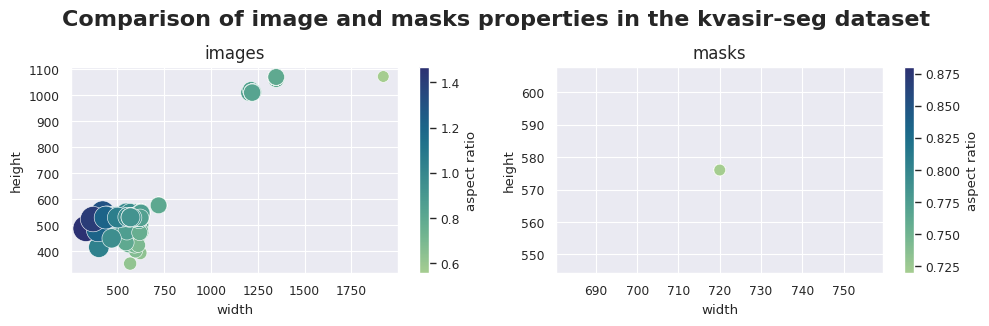

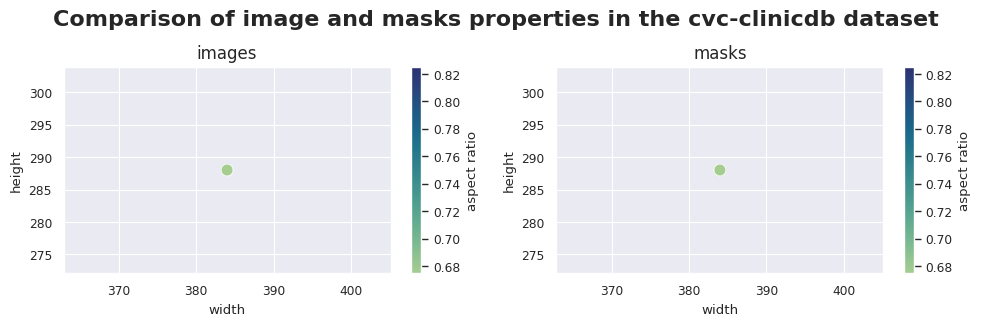

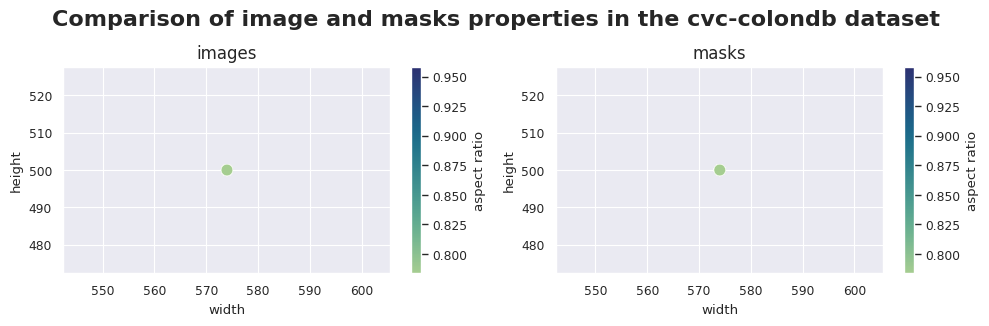

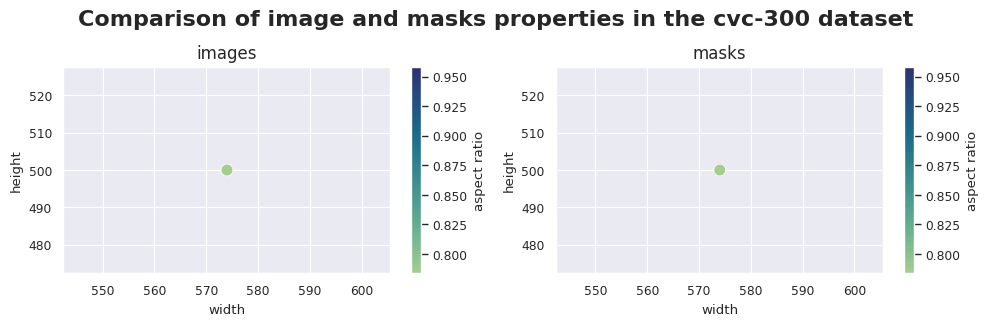

In [9]:
for dataset_name in folders:
  exec(f"dataset = {''.join(e for e in dataset_name if e.isalnum())}_join_img_msk")
  comparison_img_msk(dataset, dataset_name)
  print(f"\n")

Analyzing the figures above, the upper part shows the comparison of the kvasir-SEG dataset; the scatter plots of images and masks show how these data are distributed as a function of image width and height; it can be seen that most of the data are concentrated in the lower dimensions, around 600x500, and some others in the higher dimensions. This indicates that the images in the Kvasir-SEG dataset do not have a normalized size, which can also be confirmed with the third axis, the aspect ratio. Furthermore, the parity between these two plots confirms that the images and masks correspond in size and quantity, as expected.

As in the previous analysis, in the next cases we can state that the images and masks in the cvc-clinicdb, cvc-colondb and cvc-300 datasets have a normalized size, also corresponding in size and quantity.

## Image visualization

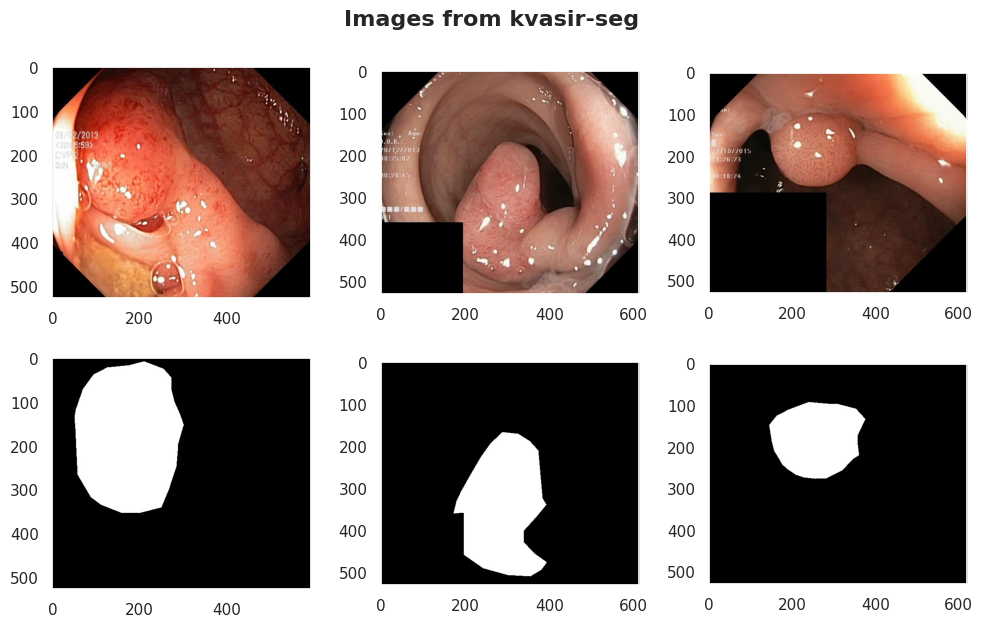

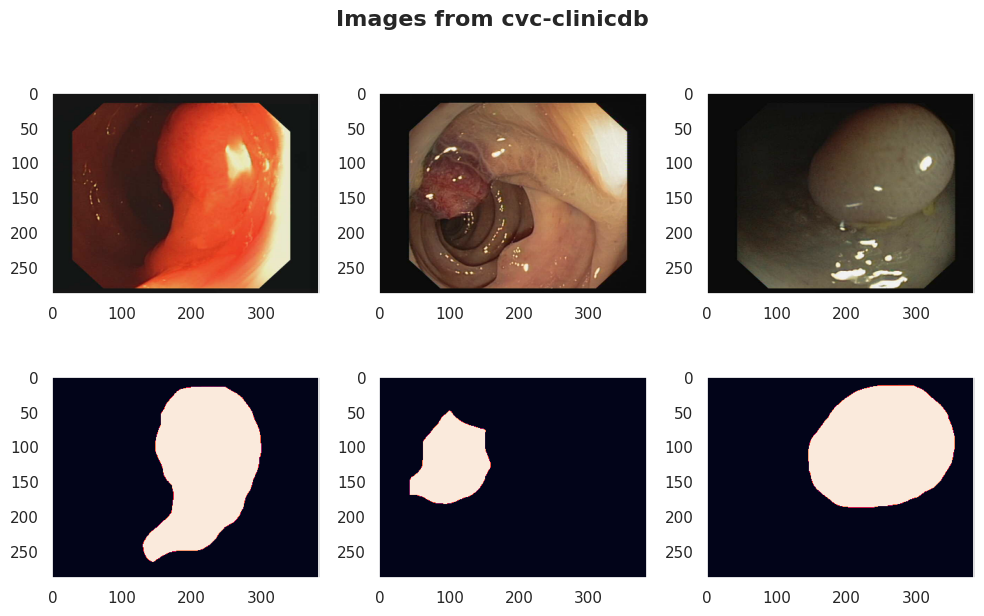

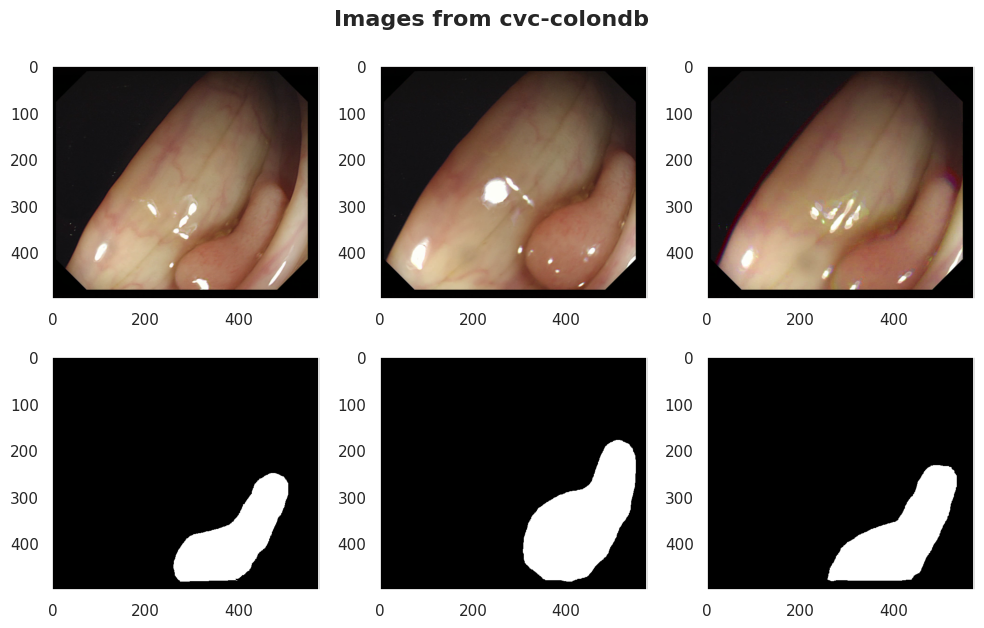

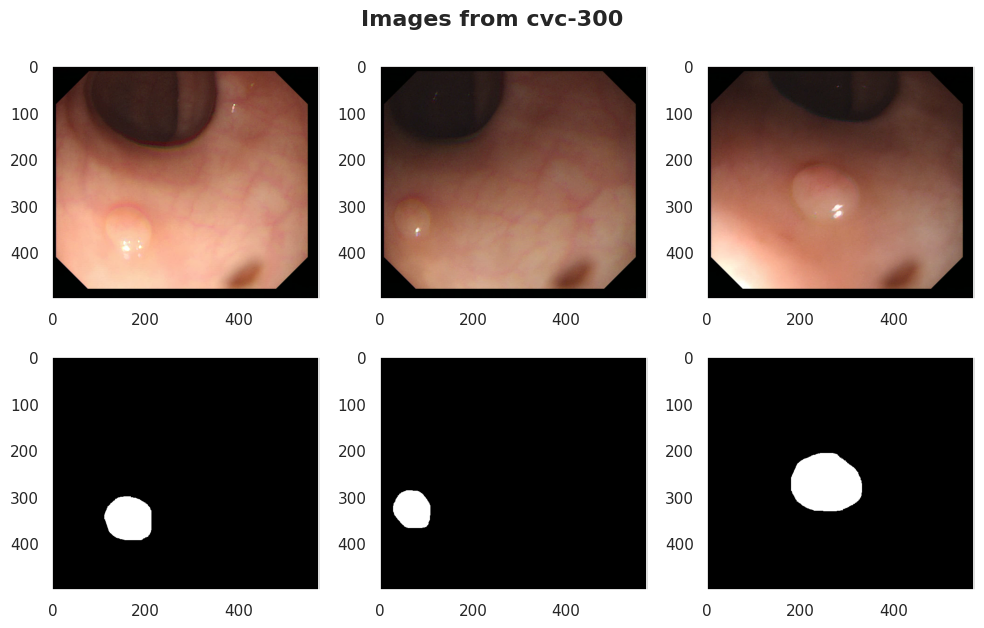

In [10]:
for folder in folders:
  images_visualization(3,folder,directory)
  print(f"\n")


## Conclusions

After exploring the data, it can be said that both datasets can be used to train models to help identify polyps in colonoscopy videos. But they are not necessarily in the best mode or have the properties to perform the best model performance.

Throughout the development of this project, multiple attempts will be made by performing transformations and merging the original data sets in order to find the best performance.

# Referencias

1. Bernal, J., Sánchez, F. J., Fernández-Esparrach, G., Gil, D., Rodríguez, C., & Vilariño, F. (2015). WM-DOVA maps for accurate polyp highlighting in colonoscopy: Validation vs. saliency maps from physicians. Computerized Medical Imaging and Graphics, 43, 99-111. [CVC-ClinicDB](https://polyp.grand-challenge.org/CVCClinicDB/)


2. Jha, D., Smedsrud, P. H., Riegler, M. A., Halvorsen, P., de Lange, T., Johansen, D., & Johansen, H. D. (2020). Kvasir-seg: A segmented polyp dataset. In International Conference on Multimedia Modeling (pp. 451-462). Springer. [Kvasir-SEG](https://datasets.simula.no/kvasir-seg/)
  

3. Sánchez, F. J., Bernal, J., Sánchez-Montes, C., de Miguel, C. R., & Fernández-Esparrach, G. (2017). Bright spot regions segmentation and classification for specular highlights detection in colonoscopy videos. Machine Vision and Applications, 28(8), 917-936. [CVC-300 (EndoScene)](http://adas.cvc.uab.es/endoscene)

  
 4. Bernal, J., Sánchez, J., & Vilarino, F. (2012). Towards automatic polyp detection with a polyp appearance model. Pattern Recognition, 45(9), 3166-3182. [CVC-ColonDB](http://mv.cvc.uab.es/projects/colon-qa/cvc-colondb)
